<a href="https://colab.research.google.com/github/abhiraman/Capstone_Project/blob/main/M_C_Transliteration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Dependencies

In [21]:
import xml.etree.ElementTree as ET
from torch.utils.data import Dataset,DataLoader
import string,re
import torch
from torch.nn.utils.rnn import pack_padded_sequence
import torch.nn as nn
import torch.optim as optim
from IPython.display import clear_output
import matplotlib.pyplot as plt
import random

# Load Data from GitHub

In [22]:
!git clone -l -s git://github.com/GokulNC/NLP-Exercises cloned-repo

fatal: destination path 'cloned-repo' already exists and is not an empty directory.


In [23]:
%cd cloned-repo

/gdrive/My Drive/Capstone_project_data/cloned-repo


In [24]:
%cd Transliteration-Indian-Languages/Original-NEWS2012-data/Training
!ls

/gdrive/My Drive/Capstone_project_data/cloned-repo/Transliteration-Indian-Languages/Original-NEWS2012-data/Training
model.pt			  NEWS2012-Training-EnKa-11955.xml
NEWS2012-Training-EnBa-14623.xml  NEWS2012-Training-EnMa-9000.xml
NEWS2012-Training-EnHe-11501.xml  NEWS2012-Training-EnTa-11957.xml
NEWS2012-Training-EnHi-13937.xml


In [5]:
if torch.cuda.is_available():
  MyDevice = 'cuda'
else:MyDevice = 'cpu'
print(MyDevice)

cpu


Getting all Hindi & English letters

In [6]:
## Get all hindi consonants ##
# Hindi Unicode Hex Range is 2304:2432. Source: https://en.wikipedia.org/wiki/Devanagari_(Unicode_block)
pad = "PAD"
hindi_alphabets = [pad]+[chr(alpha) for alpha in range(2304, 2432)]
hindi_alphabets_indexed = {hindi_alphabets[i]:i for i in range(len(hindi_alphabets))}
print(hindi_alphabets_indexed)

english_alphabets = string.ascii_uppercase
english_alphabets_indexed = {}
english_alphabets_indexed[pad]=0
for ind,char in enumerate(english_alphabets,start=1):
  english_alphabets_indexed[char] = ind
print(len(english_alphabets_indexed))

{'PAD': 0, 'ऀ': 1, 'ँ': 2, 'ं': 3, 'ः': 4, 'ऄ': 5, 'अ': 6, 'आ': 7, 'इ': 8, 'ई': 9, 'उ': 10, 'ऊ': 11, 'ऋ': 12, 'ऌ': 13, 'ऍ': 14, 'ऎ': 15, 'ए': 16, 'ऐ': 17, 'ऑ': 18, 'ऒ': 19, 'ओ': 20, 'औ': 21, 'क': 22, 'ख': 23, 'ग': 24, 'घ': 25, 'ङ': 26, 'च': 27, 'छ': 28, 'ज': 29, 'झ': 30, 'ञ': 31, 'ट': 32, 'ठ': 33, 'ड': 34, 'ढ': 35, 'ण': 36, 'त': 37, 'थ': 38, 'द': 39, 'ध': 40, 'न': 41, 'ऩ': 42, 'प': 43, 'फ': 44, 'ब': 45, 'भ': 46, 'म': 47, 'य': 48, 'र': 49, 'ऱ': 50, 'ल': 51, 'ळ': 52, 'ऴ': 53, 'व': 54, 'श': 55, 'ष': 56, 'स': 57, 'ह': 58, 'ऺ': 59, 'ऻ': 60, '़': 61, 'ऽ': 62, 'ा': 63, 'ि': 64, 'ी': 65, 'ु': 66, 'ू': 67, 'ृ': 68, 'ॄ': 69, 'ॅ': 70, 'ॆ': 71, 'े': 72, 'ै': 73, 'ॉ': 74, 'ॊ': 75, 'ो': 76, 'ौ': 77, '्': 78, 'ॎ': 79, 'ॏ': 80, 'ॐ': 81, '॑': 82, '॒': 83, '॓': 84, '॔': 85, 'ॕ': 86, 'ॖ': 87, 'ॗ': 88, 'क़': 89, 'ख़': 90, 'ग़': 91, 'ज़': 92, 'ड़': 93, 'ढ़': 94, 'फ़': 95, 'य़': 96, 'ॠ': 97, 'ॡ': 98, 'ॢ': 99, 'ॣ': 100, '।': 101, '॥': 102, '०': 103, '१': 104, '२': 105, '३': 106, '४': 107, '५': 108, '६': 109, '७': 11

Clean String Lines

In [7]:
non_eng_letters_regex = re.compile('[^a-zA-Z ]')
def _cleanEnglishWord(line):
  line = line.replace('-',' ').replace(',',' ').upper()
  line = non_eng_letters_regex.sub('', line)
  return line.split()

def _cleanLanguageWord(line):
  line = line.replace('-',' ').replace(',',' ')
  cleanedStr = ''
  for eChar in line:
    if eChar in  hindi_alphabets or eChar in ' ':
      cleanedStr+=eChar
  return cleanedStr.split()


# Custom Data Loader

In [8]:
class TextLoader(Dataset):
  def __init__(self,xmlFile=None):
    super().__init__()
    self.fileName = xmlFile
    self.allEngWords,self.allHindiWords = [],[]
    self._read_clean_data()
    self.shuffleIndices = list(range(len(self.allEngWords)))
    random.shuffle(self.shuffleIndices)
    self.startIndex = 0

  def __len__(self):
    return len(self.allEngWords)

  def _read_clean_data(self):
    tree = ET.parse(self.fileName)
    root = tree.getroot()
    for child in root:
      engWord = _cleanEnglishWord(child[0].text)
      hindWord = _cleanLanguageWord(child[1].text)
      if len(engWord)!=len(hindWord):
        print("Skipping --> {} --- {}".format(child[0].text,child[1].text))
      for eWord in engWord:
        self.allEngWords.append(eWord)
      for eWord in hindWord:
        self.allHindiWords.append(eWord)

  def __getitem__(self,idx):
    return {"EnglishWord":self.allEngWords[idx],"HindiWord":self.allHindiWords[idx]}
  
  def _get_batch_words(self,batchSize,array):
    end= self.startIndex + batchSize
    batch = []
    return batch + [array[self.shuffleIndices[i]] for i in range(end)]
  
  def _return_batch_words(self,batchSize):
    engWords = self._get_batch_words(batchSize,self.allEngWords)
    hindiWords = self._get_batch_words(batchSize,self.allHindiWords)
    return engWords,hindiWords

dataSet = TextLoader(xmlFile='NEWS2012-Training-EnHi-13937.xml')

In [9]:
for ind,i in enumerate(dataSet):
  if ind>5:break
  print(i)

{'EnglishWord': 'RAASAVIHAAREE', 'HindiWord': 'रासविहारी'}
{'EnglishWord': 'DEOGAN', 'HindiWord': 'देवगन'}
{'EnglishWord': 'ROAD', 'HindiWord': 'रोड'}
{'EnglishWord': 'SHATRUMARDAN', 'HindiWord': 'शत्रुमर्दन'}
{'EnglishWord': 'MAHIJUBA', 'HindiWord': 'महिजुबा'}
{'EnglishWord': 'SABINE', 'HindiWord': 'सैबिन'}


In [10]:
def word_rep(word, letter2index, device = 'cpu'):
    rep = torch.zeros(len(word)+1, 1, len(letter2index)).to(device)
    for letter_index, letter in enumerate(word):
        pos = letter2index[letter]
        rep[letter_index][0][pos] = 1
    pad_pos = letter2index["PAD"]
    rep[letter_index+1][0][pad_pos] = 1
    return rep

def gt_rep(word, letter2index, device = 'cpu'):
    gt_rep = torch.zeros([len(word)+1, 1], dtype=torch.long).to(device)
    for letter_index, letter in enumerate(word):
        pos = letter2index[letter]
        gt_rep[letter_index][0] = pos
    gt_rep[letter_index+1][0] = letter2index["PAD"]
    return gt_rep

Mount Drive

In [11]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [12]:
%cd /gdrive/MyDrive/Capstone_project_data
!ls

/gdrive/MyDrive/Capstone_project_data
 cloned-repo  'Synthetic Train Set - Detection & Recognition'
 ImgtoText    'Synthetic Train Set - Detection & Recognition.zip'
 model.pt


Enoder Decoder W/O Attention

In [13]:
class Encoder_Decoder(nn.Module):
  def __init__(self,inputSize,hiddenSize,outputSize,num_layers =1,num_dirns=1,verbose=True):
    super().__init__()
    self.hiddenSize = hiddenSize
    self.outputSize = outputSize
    self.num_layers = num_layers
    self.num_dirns = num_dirns
    self.encoder_GRU = nn.GRU(inputSize,hiddenSize)
    self.decoder_GRU = nn.GRU(outputSize,hiddenSize)
    self.h2o = nn.Linear(hiddenSize,outputSize)
    self.F = nn.LogSoftmax(dim=2)
    self.Fll = nn.Softmax(dim=2)
    self.verbose = verbose
  
  def forward(self,inputs,maxCharLen,GT=None,trainFlag =True,device='cpu'):
    all_hidden,last_hidden = self.encoder_GRU (inputs)

    if self.verbose:
      print("Encoder Input : ",inputs.size())
      print("Encoder All Hidden Outputs : ",all_hidden.size())
      print("Encoder Last Hidden Output : ",last_hidden.size())


    decoder_state = last_hidden
    decoderInput = torch.zeros(1,all_hidden.size()[1],self.outputSize).to(device) ##(1,batchSize,no.of English Alphabets)
    if self.verbose:
      print("Decoder Input : ",decoderInput.size())
    

    outputlist = []   
    for i in range(maxCharLen):
      out,decoder_state = self.decoder_GRU(decoderInput,decoder_state)
      output = self.h2o(decoder_state)
      output = self.F(output)

      if trainFlag:
        outputlist.append(output.view(1, -1))
      else:
        output_eval = self.Fll(self.h2o(out))
        outputlist.append(output_eval.squeeze(0))
      if self.verbose:
        print("Decoder Ouput : ",output.size())
        print("Squeezed Final Output : ",output.squeeze(0).size())
        

      maxIndexes = torch.argmax(output,dim=2,keepdim=True).type(torch.int64)
      if GT!=None:
        maxIndexes = GT[i].reshape(1, 1, 1)

      one_hot = torch.FloatTensor(output.size()).to(device)
      one_hot.zero_()
      one_hot.scatter_(2,maxIndexes,1)
      decoderInput = one_hot.detach()
    return outputlist
      



In [28]:
def trainBatch(modelObj,batchSize,optFn,LossFn,enforceTrain=False,device='cpu'):
  textLoaderObj = TextLoader(xmlFile='NEWS2012-Training-EnHi-13937.xml')
  engList,hindiList = textLoaderObj._return_batch_words(batchSize)

  total_loss = 0
  batch_counter = 0
 
  for eWord,hWord in zip(engList,hindiList):
    inputs,targets = word_rep(hWord,hindi_alphabets_indexed,device=device),gt_rep(eWord,english_alphabets_indexed,device=device)
    pred_ouputs = modelObj(inputs,len(targets),GT= targets if enforceTrain else None,device=device)
    ## Loss & Gradient compute for evry time step ##
    for index,ouputs in enumerate(pred_ouputs):
      loss = LossFn(ouputs,targets[index])/batchSize ## Loss per word
      loss.backward(retain_graph=True)
      total_loss+=loss.item()        ## Total Loss per batch
  

  return total_loss/batchSize   ## Total Loss per Epoch



In [55]:
def training_helper(net,lr=0.5,batch_size=100,epochs=11,momentum = 0.9, display_freq=5, device = 'cpu'):
  net.to(device)
  lossFn = nn.NLLLoss(ignore_index = -1)
  optFn = optim.Adam(modelObj.parameters(),lr=lr)
  enforce_Till = epochs//3
  sheduler = optim.lr_scheduler.StepLR(optFn,step_size=100,gamma=0.5)
  


  loss_per_epoch_array = torch.zeros(epochs+1)
  minVal= 1000000
  for i in range(epochs):
    optFn.zero_grad()
    loss_per_epoch_array[i+1] = (loss_per_epoch_array[i]*i + trainBatch(net, batch_size,optFn, lossFn, device = device, enforceTrain=True if i<enforce_Till else False ))/(i + 1)
    optFn.step()
    sheduler.step()
    
    if sheduler.get_lr()!=sheduler.get_last_lr():
      print(sheduler.get_lr())

    if loss_per_epoch_array[i]<minVal and i>0:
      minVal = loss_per_epoch_array[i]
      torch.save(net,'model.pt')

    if i%display_freq == 0 and i!=0: ## Every 5 epochs refresh the loss plot ##
      clear_output(wait=True)
      print("For Epoch {} ----> Loss {}".format(i,loss_per_epoch_array[i]))
      plt.figure()
      plt.plot(loss_per_epoch_array[1:i],'-*')
      plt.xlabel("Epochs")
      plt.ylabel("Epoch Loss")
      plt.show()
  return loss_per_epoch_array


In [56]:
## HyperParameters ##
hiddensize = 256
lr = 0.005
momentum = 0.9
batch_size=64

In [57]:
modelObj = Encoder_Decoder(len(hindi_alphabets_indexed),hiddensize,len(english_alphabets_indexed),verbose=False)

For Epoch 990 ----> Loss 0.15560877323150635


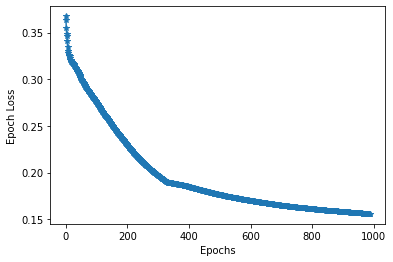

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


[2.44140625e-06]


tensor([0.0000, 0.3675, 0.3634,  ..., 0.1555, 0.1554, 0.1555])

In [59]:
training_helper(modelObj,lr=lr, momentum = momentum,batch_size=batch_size,epochs=1000,display_freq=10,device=MyDevice)

In [60]:
torch.load('model.pt',map_location=torch.device('cpu'))

Encoder_Decoder(
  (encoder_GRU): GRU(129, 256)
  (decoder_GRU): GRU(27, 256)
  (h2o): Linear(in_features=256, out_features=27, bias=True)
  (F): LogSoftmax(dim=2)
  (Fll): Softmax(dim=2)
)

In [84]:
def test(net,data,tar_len,device='cpu'):
  key,val = list(english_alphabets_indexed.keys()),english_alphabets_indexed.values()
  net.eval().to(device)
  outputs = net(data,tar_len,trainFlag=False)
  convertedList = [[] for i in range(outputs[0].size()[0])]
  for eTensor in outputs:
    indexes = torch.argmax(eTensor,dim=1).tolist()
    strr = ''
    for i,index in enumerate(indexes):
      strr = key[index]
      convertedList[i].append(strr)
  return convertedList

textLoaderObj = TextLoader(xmlFile='NEWS2012-Training-EnHi-13937.xml')
engList,hindiList = textLoaderObj._return_batch_words(10)
key = list(hindi_alphabets_indexed.keys())

i=0
for eWord,hWord in zip(engList,hindiList):
  inputs,targets = word_rep(hWord,hindi_alphabets_indexed,device=MyDevice),gt_rep(eWord,english_alphabets_indexed,device=MyDevice)
  pred = test(modelObj,inputs,len(targets))
  tempList = []
  for eTensor in inputs:
    maxIndex = torch.argmax(eTensor,dim=1)
    tempList.append(key[int(maxIndex.item())])

  pred = ["".join(eChar) for eList in pred for eChar in eList  if eChar!='PAD' ]
  tempList = ["".join(eChar) for eChar in tempList]
  print(pred,tempList)
  i+=1
  if i>5:break

  

['G', 'E', 'T', 'T'] ['ग', 'े', 'ट', 'PAD']
['B', 'R', 'O', 'O', 'N'] ['ब', '्', 'र', 'ा', 'उ', 'न', 'PAD']
['S', 'A', 'R', 'G', 'A', 'G', 'I'] ['स', 'र', 'ा', 'ज', 'े', 'व', 'ो', 'PAD']
['S', 'E', 'M', 'I', 'L', 'O', 'L', 'L'] ['स', 'े', 'म', 'ी', 'न', 'ो', 'ल', 'PAD']
['A', 'R', 'R', 'A', 'D'] ['ए', 'र', '्', 'ड', 'र', 'ा', 'PAD']
['A', 'N', 'N', 'A', 'A', 'D', 'I', 'I'] ['आ', 'न', 'ं', 'द', 'म', 'य', 'ी', 'PAD']


In [ ]:
batchSize = 1
testSet = TextLoader(xmlFile='NEWS2012-Testing-EnHi-1000.xml')
data = DataLoader(dataSet,batch_size=batchSize,shuffle=True,collate_fn=CustomWordLoader())


In [ ]:
aa = [1,2,3,5,6]
b= 0
if b<